# Entrenamiento de MNIST con PyTorch & Elastic Inference

Este notebook, y el codigo para esta clase esta basado en los repositorios oficiales de AWS. Si deseas revisar mas ejemplos, porfavor visita:   
https://github.com/aws/amazon-sagemaker-examples

## Contents

1. [Preliminares](#Preliminares)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)

---

## Preliminares

MNIST es el set de datos que utilizamos cuando aprendimos PyTorch en la clase de Aprendizaje Maquina 2. Es conocido por sel el 'Hello World' de redes neuronales. Los datos consisten de 70 mil imagenes de 28x28 pixeles, en escala de digitos. Cada imagen contiene un digito entre 0-9. En este Notebook entrenaremos una red neuronal en Amazon Sage Maker usando PyTorch, y depues la llevaremos a produccion haciendo uso del servicio de Elastic Inference, que nos permite escalar recursos al momento de evaluar nuestros modelos, pero a bajo costo.

Para mas informacion de PyTorch en SageMaker, visita [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers), y [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.

---

## Setup

Let's start by creating a SageMaker session and specifying:
- Creemos un bucket de S3, y un prefijo para nombrar nuestro entrenamiento, y modelo. **El bucket debe encontrarse en la misma region que la instancia de S3**
- Necesitaremos un rol de IAM para darle acceso al entrenamiento y hosting. Asegurate de tenerlo creado.


In [ ]:
import sagemaker
from sagemaker.local import LocalSession

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-mnist'

role = sagemaker.get_execution_role()

## Data
### Descarguemos los Datos



In [ ]:
pip install torchvision==0.5.0 --no-cache-dir

In [ ]:
from torchvision import datasets, transforms

datasets.MNIST('data', download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))

### Subiremos los archivos a S3
Usaremos la funcion `sagemaker.Session.upload_data` para cargar nuestros datos al bucket de S3 que definimos mas arriba. El valor que nos regresa identifica el directorio donde se encuentran. 


In [ ]:
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix=prefix)
print('input spec (path de S3): {}'.format(inputs))

## Train
### Training script
El archivo `mnist.py` contiene el pipe/codigo necesario para entrenar y hostear nuestro modelo en SageMaker. Como tal contiene una arquitectura para nuestra red. Si deseamos modificarla lo recomendable seria hacerlo sobre se mismo archivo. Este script es proporcionado por Amazon en su documentacion, por lo que te recomendamos le des un vistazo, pues puedes reutilizarlo en tus modelos de pytorch.  
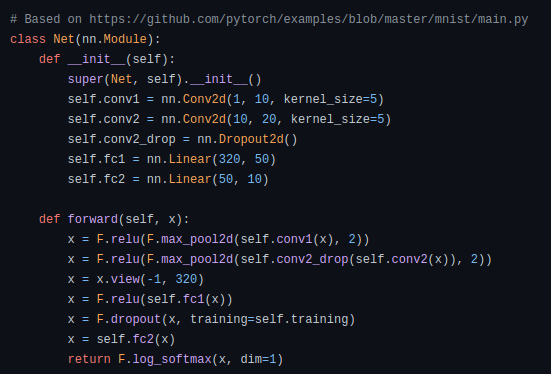



`model_fn` es la funcion que cargara nuestro modelo.  

El script es muy parecido al que utilizarias si fueramos a entrenar un modelo de PyTorch fuera de SageMaker, pero con la ventaja de que podemos interactuar con sus paremetros como variables de ambiente:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to.
  These artifacts are uploaded to S3 for model hosting.
* `SM_NUM_GPUS`: The number of gpus available in the current container.
* `SM_CURRENT_HOST`: The name of the current container on the container network.
* `SM_HOSTS`: JSON encoded list containing all the hosts .

Supposing one input channel, 'training', was used in the call to the PyTorch estimator's `fit()` method, the following will be set, following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAINING`: A string representing the path to the directory containing data in the 'training' channel.

For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers).

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance.

Because the SageMaker imports the training script, you should put your training code in a main guard (``if __name__=='__main__':``) if you are using the same script to host your model as we do in this example, so that SageMaker does not inadvertently run your training code at the wrong point in execution.

For example, the script run by this notebook:

In [ ]:
!pygmentize mnist.py

### Run training in SageMaker

The `PyTorch` class allows us to run our training function as a training job on SageMaker infrastructure. We need to configure it with our training script, an IAM role, the number of training instances, the training instance type, and hyperparameters. In this case we are going to run our training job on 2 ```ml.c4.xlarge``` instances. But this example can be ran on one or multiple, cpu or gpu instances ([full list of available instances](https://aws.amazon.com/sagemaker/pricing/instance-types/)). The hyperparameters parameter is a dict of values that will be passed to your training script -- you can see how to access these values in the `mnist.py` script above.


In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='mnist.py',
                    role=role,
                    framework_version='1.4.0',
                    py_version='py3',
                    train_instance_count=2,
                    train_instance_type='ml.c4.xlarge',
                    hyperparameters={
                        'epochs': 6,
                        'backend': 'gloo'
                    })

After we've constructed our `PyTorch` object, we can fit it using the data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our training script can simply read the data from disk.


In [ ]:
estimator.fit({'training': inputs})

In [ ]:
estimator.model_data

## Host
### Create endpoint
After training, we use the `PyTorch` estimator object to build and deploy a `PyTorchPredictor`. This creates a Sagemaker Endpoint -- a hosted prediction service that we can use to perform inference.

As mentioned above we have implementation of `model_fn` in the `mnist.py` script that is required. We are going to use default implementations of `input_fn`, `predict_fn`, `output_fn` and `transform_fm` defined in [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers).

The arguments to the deploy function allow us to set the number and type of instances that will be used for the Endpoint. These do not need to be the same as the values we used for the training job. For example, you can train a model on a set of GPU-based instances, and then deploy the Endpoint to a fleet of CPU-based instances, but you need to make sure that you return or save your model as a cpu model similar to what we did in `mnist.py`. Here we will deploy the model to a single ```ml.m4.xlarge``` instance.

In [ ]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

### Evaluate
We can now use this predictor to classify hand-written digits. Drawing into the image box loads the pixel data into a `data` variable in this notebook, which we can then pass to the `predictor`.

In [ ]:
import numpy as np
im_ = np.random.rand(1,1,28,28)

image = np.array(im_, dtype=np.float32)
response = predictor.predict(image)
prediction = response.argmax(axis=1)[0]
print(prediction)

### Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it

In [ ]:
estimator.delete_endpoint()

## Elastic Inference

Selecting the right instance type for inference requires deciding between different amounts of GPU, CPU, and memory resources, and optimizing for one of these resources on a standalone GPU instance usually leads to under-utilization of other resources. [Amazon Elastic Inference](https://aws.amazon.com/machine-learning/elastic-inference/) solves this problem by enabling us to attach the right amount of GPU-powered inference acceleration to our endpoint. In March 2020, [Elastic Inference support for PyTorch became available](https://aws.amazon.com/blogs/machine-learning/reduce-ml-inference-costs-on-amazon-sagemaker-for-pytorch-models-using-amazon-elastic-inference/) for both Amazon SageMaker and Amazon EC2. For supported images, check [available images in Elastic Inference Containers section](https://github.com/aws/deep-learning-containers/blob/master/available_images.md)

To use Elastic Inference, we must convert our trained model to TorchScript. The location of the model artifacts is estimator.model_data.

In [ ]:
estimator.model_data

First we create a folder to save model trained model, and download the model.tar.gz file to local directory.

In [ ]:
%%sh -s $estimator.model_data
mkdir model
aws s3 cp $1 model/ 
tar xvzf model/model.tar.gz --directory ./model

Convert your model into the TorchScript format using torch.jit.trace or torch.jit.script.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model_loaded = torch.load("model/model.pth")
model = Net().to("cpu")
model = torch.nn.DataParallel(model)
model.load_state_dict(model_loaded)

In [ ]:
import subprocess

trace_input = torch.rand(1,1,28,28)
traced_model= torch.jit.trace(model.eval(), trace_input)

torch.jit.save(traced_model, "model.pth")
subprocess.call(["tar", "-czvf", "traced_mnist_model.tar.gz", "model.pth"])

Loading the TorchScript model and using it for prediction require small changes in our model loading and prediction functions. We create a new script deploy_ei.py that is slightly different from train_deploy.py script.

**Notes:** Elastic Inference images are using different apis for PyTorch 1.3.1 and PyTorch 1.5.1. If you are using PyTorch 1.3.1, you can leave deploy_ei.py empty since we provide default handler for you. If you are using PyTorch 1.5.1, create a script like deploy_ei.py. Please use `attach_eia` in `model_fn`. 

In [ ]:
!pygmentize code/deploy_ei.py

Next we upload TorchScript model to S3 and deploy using Elastic Inference. The accelerator_type=ml.eia2.xlarge parameter is how we attach the Elastic Inference accelerator to our endpoint.

In [ ]:
from sagemaker.pytorch import PyTorchModel

instance_type = 'ml.m5.large'
accelerator_type = 'ml.eia2.xlarge'

# TorchScript model
tar_filename = 'traced_mnist_model.tar.gz'

# You can also upload model artifacts to S3
# print('Upload tarball to S3')
# model_data = sagemaker_session.upload_data(path=tar_filename, bucket=bucket, key_prefix=prefix)
model_data = tar_filename

endpoint_name = 'mnist-ei-traced-{}-{}'.format(instance_type, accelerator_type).replace('.', '').replace('_', '')


In [ ]:
pytorch = PyTorchModel(
    model_data=model_data,
    role=role,
    entry_point='deploy_ei.py',
    source_dir='code',
    framework_version='1.3.1',
    py_version='py3',
    sagemaker_session=sagemaker_session
)


You can attach EI remotely or locally

In [ ]:
# Attach EI remotely

# Function will exit before endpoint is finished creating
predictor = pytorch.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    accelerator_type=accelerator_type,
    endpoint_name=endpoint_name,
    wait=True
)


# # Attach EI locally

# # Deploys the model to a local endpoint
# pytorch_predictor = pytorch.deploy(
#     initial_instance_count=1,                      
#     instance_type='local',
#     accelerator_type='local_sagemaker_notebook')

In [ ]:
predictor.delete_endpoint()